In [1]:
# Импорты + зафиксируем все ,что можно

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop,SGD

# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(123)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(123)

#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)


Using Theano backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 10

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [4]:
# Создаем модель и фиксируем seed в слоях Dropout
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2,seed=123))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2,seed=123))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer="SGD",
              metrics=['accuracy'])

# Сохраним начальные веса модели
path_0 = "start_weights.h5" # путь к файлу с начальными весами
model.save_weights(filepath=path_0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Тренируем изолированную модель

In [5]:
# Тренируем изолированную модель

print("Изолированная модель")
score_loss_I, score_accuracy_I =  [],[]

for attempt in range(10): # произведем 10 экспериментов

    model.load_weights(filepath=path_0) # загрузим в модельначальные веса

    path = "temp_weights.h5" # путь к файлу с промежуточными весами
    
    # Обучаем модель. После каждой эпохи выгружаем веса в файл, перекомпилируем модель и
    # загружаем веса обратно
    for i in range(epochs):
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=1,
                            verbose=0,
                            validation_data=(x_test, y_test),
                            shuffle=False)
        model.save_weights(filepath=path)
        model.compile(loss='categorical_crossentropy',
                      optimizer="SGD",
                      metrics=['accuracy'])
        model.load_weights(filepath=path)

    # Оценим результаты обучения
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Попытка №',attempt,' Test loss:', score[0], ' Test accuracy:', score[1])
    # Сохраним результаты
    score_loss_I.append(score[0])
    score_accuracy_I.append(score[1])


Изолированная модель


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Попытка № 0  Test loss: 0.21144454316198827  Test accuracy: 0.9389
Попытка № 1  Test loss: 0.21172240974754095  Test accuracy: 0.9384
Попытка № 2  Test loss: 0.21128906050920487  Test accuracy: 0.9391
Попытка № 3  Test loss: 0.2110327853769064  Test accuracy: 0.939
Попытка № 4  Test loss: 0.21096362763792276  Test accuracy: 0.9389
Попытка № 5  Test loss: 0.21090506552755833  Test accuracy: 0.9385
Попытка № 6  Test loss: 0.21137148083895446  Test accuracy: 0.9389
Попытка № 7  Test loss: 0.2115417490437627  Test accuracy: 0.9388
Попытка № 8  Test loss: 0.21129335514605047  Test accuracy: 0.9395
Попытка № 9  Test loss: 0.2112155700996518  Test accuracy: 0.9385


### Тренируем монолитную модель

In [6]:
# Тренируем монолитную модель

print("Монолитная модель")

score_loss_M, score_accuracy_M =  [],[]

for attempt in range(10): # произведем 10 экспериментов

    model.load_weights(filepath=path_0) # загрузим в модель начальные веса

    #Обучим модель
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test),
                        shuffle=False)

    # Оценим результаты обучения
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Попытка № ',attempt,' Test loss:', score[0], ' Test accuracy:', score[1])
    # Сохраним результаты
    score_loss_M.append(score[0])
    score_accuracy_M.append(score[1])

Монолитная модель
Попытка №  0  Test loss: 0.2113642861381173  Test accuracy: 0.9389
Попытка №  1  Test loss: 0.2118012183919549  Test accuracy: 0.9387
Попытка №  2  Test loss: 0.21153719843328  Test accuracy: 0.9393
Попытка №  3  Test loss: 0.2104892091035843  Test accuracy: 0.9392
Попытка №  4  Test loss: 0.21070018615722655  Test accuracy: 0.9397
Попытка №  5  Test loss: 0.21155692620277405  Test accuracy: 0.9379
Попытка №  6  Test loss: 0.21162566715925932  Test accuracy: 0.9392
Попытка №  7  Test loss: 0.21189376911520957  Test accuracy: 0.9386
Попытка №  8  Test loss: 0.21148181668072938  Test accuracy: 0.9388
Попытка №  9  Test loss: 0.21114144530594348  Test accuracy: 0.9388


### Сравнение результатов на графике

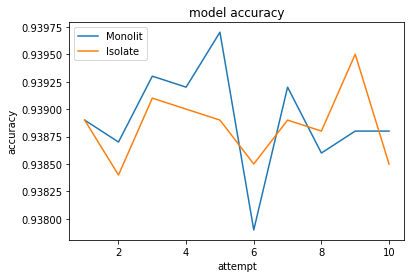

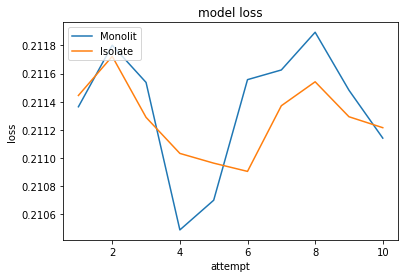

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# summarize for accuracy
plt.plot(x,score_accuracy_M)
plt.plot(x,score_accuracy_I)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('attempt')
plt.legend(['Monolit', 'Isolate'], loc='upper left')
plt.show()

# summarize for loss_M
plt.plot(x,score_loss_M)
plt.plot(x,score_loss_I)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('attempt')
plt.legend(['Monolit', 'Isolate'], loc='upper left')
plt.show()